#             _DATA MINING PROJECT:   ANDRIANO Giancarlo_

The project is based on the COVID-19 dataset taken from the Microsoft website. It shows a per-country covid history indicating each day what measures took place and the number of registerd cases and deaths. Each attribute in the dataset is a different measure, and has an integer value associeted to it depending on its severity. Broadly speaking, the measures can be grouped into 3 categories:
- contact reducing
- economic support
- investiments in public health and monitoring

More informations about the dataset are provided at the following link:

https://docs.microsoft.com/en-us/azure/open-datasets/dataset-oxford-covid-government-response-tracker?tabs=azure-storage

### _DATA PRE-PROCESSING_


This is the import section:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import fpgrowth
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy

Loading the dataset directly from the Microsoft website

In [2]:
full_data=pd.read_parquet("https://pandemicdatalake.blob.core.windows.net/public/curated/covid-19/covid_policy_tracker/latest/covid_policy_tracker.parquet")
full_data.head()

,countryname,countrycode,date,c1_school_closing,c1_flag,c2_workplace_closing,c2_flag,c3_cancel_public_events,c3_flag,c4_restrictions_on_gatherings,...,h5_investment_in_vaccines,m1_wildcard,confirmedcases,confirmeddeaths,stringencyindex,stringencyindexfordisplay,legacystringencyindex,legacystringencyindexfordisplay,iso_country,load_date
0,Aruba,ABW,2020-01-01,0.0,None,0.0,None,0.0,None,0.0,...,0.0,None,NaN,NaN,0.0,0.0,NaN,NaN,AW,2021-12-23 00:04:57.634
1,Aruba,ABW,2020-01-02,0.0,None,0.0,None,0.0,None,0.0,...,0.0,None,NaN,NaN,0.0,0.0,NaN,NaN,AW,2021-12-23 00:04:57.634
2,Aruba,ABW,2020-01-03,0.0,None,0.0,None,0.0,None,0.0,...,0.0,None,NaN,NaN,0.0,0.0,NaN,NaN,AW,2021-12-23 00:04:57.634
3,Aruba,ABW,2020-01-04,0.0,None,0.0,None,0.0,None,0.0,...,0.0,None,NaN,NaN,0.0,0.0,NaN,NaN,AW,2021-12-23 00:04:57.634
4,Aruba,ABW,2020-01-05,0.0,None,0.0,None,0.0,None,0.0,...,0.0,None,NaN,NaN,0.0,0.0,NaN,NaN,AW,2021-12-23 00:04:57.634


#### Attributes selection

I am not interested in those columns:

- stringencyindexfordisplay
- stringencyindex
- load_date
- iso_country     -> redundant info
- countryname     -> redundant info


Furthermore, I'm dropping all the columns with redundant Boolean values. This will be helpful later for the Dimensionality Reduction using PCA.



In [3]:
flagged_attributes=['c'+str(x) for x in range(1,8)]+['e1','h1']
to_remove_attr= [el+'_flag' for el in flagged_attributes]
to_remove_attr+=['stringencyindexfordisplay','m1_wildcard','stringencyindex','load_date','iso_country','countryname','legacystringencyindex','legacystringencyindexfordisplay']

data=full_data.drop(to_remove_attr,axis=1)
data.head()


,countrycode,date,c1_school_closing,c2_workplace_closing,c3_cancel_public_events,c4_restrictions_on_gatherings,c5_close_public_transport,c6_stay_at_home_requirements,c7_restrictions_on_internal_movement,c8_international_travel_controls,...,e2_debt/contract_relief,e3_fiscal_measures,e4_international_support,h1_public_information_campaigns,h2_testing_policy,h3_contact_tracing,h4_emergency_investment_in_healthcare,h5_investment_in_vaccines,confirmedcases,confirmeddeaths
0,ABW,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,ABW,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,ABW,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,ABW,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,ABW,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


#### Dropping rows with null values

In [4]:
print('DATA SIZE BEFORE: ',data.size)
data=data.dropna()
print('DATA SIZE AFTER : ',data.size)

data.head()

DATA SIZE BEFORE:  4730544
DATA SIZE AFTER :  1837101


,countrycode,date,c1_school_closing,c2_workplace_closing,c3_cancel_public_events,c4_restrictions_on_gatherings,c5_close_public_transport,c6_stay_at_home_requirements,c7_restrictions_on_internal_movement,c8_international_travel_controls,...,e2_debt/contract_relief,e3_fiscal_measures,e4_international_support,h1_public_information_campaigns,h2_testing_policy,h3_contact_tracing,h4_emergency_investment_in_healthcare,h5_investment_in_vaccines,confirmedcases,confirmeddeaths
21,ABW,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,ABW,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,ABW,2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,ABW,2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,ABW,2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### EU Countries Filtering

I'm interested only in Europe, so I filter out all other countries:

In [5]:
eu_countries=list(map(str.strip,'AUT, BEL, BGR, HRV, CYP, CZE, DNK, EST, FIN, FRA, DEU, GRC, HUN, IRL, ITA, LVA, LTU, LUX, MLT, NLD, POL, PRT, ROU, SVK, SVN, ESP, SWE'.split(',')))

eu_countries.remove('BGR') # Sorry guys

data=data[data['countrycode'].isin(eu_countries)]

#### Data Aggregation: DAILY --> 2 WEEKS

This helps removing redundant data, especially at the beginning where not all European Countries started registering covid cases simultaneously, so they have many all-0 rows. The SUM() aggregation function is used, in order to sum  the positive cases and to have an integer value for each measure: the higher the value the more severe is the restriction/action.

In [6]:
# converting the date into Pandas datetime format
data['date'] = pd.to_datetime(data['date'])


# ALL SUMMED DATA REGARDING ALL EUROPE
data = data.groupby([pd.Grouper(key='date', freq='2W')]).sum()
print(data.shape[0])

data = data.reset_index()
data.head()



33


,date,c1_school_closing,c2_workplace_closing,c3_cancel_public_events,c4_restrictions_on_gatherings,c5_close_public_transport,c6_stay_at_home_requirements,c7_restrictions_on_internal_movement,c8_international_travel_controls,e1_income_support,e2_debt/contract_relief,e3_fiscal_measures,e4_international_support,h1_public_information_campaigns,h2_testing_policy,h3_contact_tracing,h4_emergency_investment_in_healthcare,h5_investment_in_vaccines,confirmedcases,confirmeddeaths
0,2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.000000e+00,0.0,14.0,8.0,22.0,0.000000e+00,0.00,8.0,0.0
1,2020-02-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127.0,0.0,0.0,0.000000e+00,258176.0,222.0,144.0,166.0,0.000000e+00,8257298.00,270.0,0.0
2,2020-02-23,3.0,6.0,2.0,4.0,0.0,2.0,5.0,182.0,0.0,0.0,0.000000e+00,0.0,278.0,168.0,210.0,0.000000e+00,0.00,725.0,15.0
3,2020-03-08,99.0,42.0,79.0,97.0,0.0,34.0,21.0,252.0,22.0,19.0,1.261113e+10,312515.0,512.0,262.0,334.0,1.891352e+06,0.00,48927.0,1429.0
4,2020-03-22,683.0,425.0,546.0,634.0,107.0,208.0,203.0,814.0,263.0,176.0,2.524416e+11,4253000.0,643.0,320.0,359.0,1.051008e+10,87834168.52,681717.0,24118.0


### _DIMENSIONALITY REDUCTION: PCA_

As mentioned at the beginning, the attributes are mainly divided into 3 categories:
- contacts reducing: c1 --> c8
- economic support : e1 --> e4
- health and monitoring: h1 --> h5

PCA will be applied to these sets of attributes, and the first principal component of each set will be insered in the final dataset. So in the end the final table will have only the previously mentioned attributes plus country code, date and confirmed cases.

In [7]:

columns=data.columns

c_cols = columns[1:9] # c1 --> c8
contacts_reducing=data[c_cols].copy()
#print(c_cols)

e_cols = columns[9:13] # e1 --> e4
economic=data[e_cols].copy()
#print(e_cols)

h_cols = columns[13:len(columns)-2] # h1 --> h5  without confirmed cases/deaths
health_and_monitor=data[h_cols].copy() 
#print(h_cols)


# SCALING  AND TRANSFORMING DATA
c_scaled=StandardScaler().fit(contacts_reducing).transform(contacts_reducing)
e_scaled=StandardScaler().fit(economic).transform(economic)
h_scaled=StandardScaler().fit(health_and_monitor).transform(health_and_monitor)

n_components=1

# PCA for each main component
c_PCA=PCA(n_components=n_components).fit(c_scaled).transform(c_scaled).tolist()
e_PCA=PCA(n_components=n_components).fit(e_scaled).transform(e_scaled).tolist()
h_PCA=PCA(n_components=n_components).fit(h_scaled).transform(h_scaled).tolist()


c_PCA = pd.Series([float(el[0]) for el in c_PCA])
e_PCA = pd.Series([float(el[0]) for el in e_PCA])
h_PCA = pd.Series([float(el[0]) for el in h_PCA])



data_PCA=pd.DataFrame({'contacts_reducing':c_PCA,'economic':e_PCA,'health_and_monitor':h_PCA})
data_PCA.insert(0,'date', data['date'] )
data_PCA.insert(4,'cases',data['confirmedcases'])
data_PCA.insert(5,'deaths',data['confirmeddeaths'])
data_PCA.head()

,date,contacts_reducing,economic,health_and_monitor,cases,deaths
0,2020-01-26,-2.625238,-1.539191,-2.190430,8.0,0.0
1,2020-02-09,-2.493190,-1.532949,-0.727066,270.0,0.0
2,2020-02-23,-2.389066,-1.539191,-0.379533,725.0,15.0
3,2020-03-08,-1.732028,-1.303221,0.938919,48927.0,1429.0
4,2020-03-22,3.273932,1.837653,1.958162,681717.0,24118.0


Re-dimensioning confirmed cases/deaths with respect to the peak:

In [21]:
data_PCA['cases'] = data_PCA['cases']/data_PCA['cases'].max()
data_PCA['deaths'] = data_PCA['deaths']/data_PCA['deaths'].max()
data_PCA.head()

,date,contacts_reducing,economic,health_and_monitor,cases,deaths
0,2020-01-26,-2.625238,-1.539191,-2.190430,0.000003,0.000000
1,2020-02-09,-2.493190,-1.532949,-0.727066,0.000114,0.000000
2,2020-02-23,-2.389066,-1.539191,-0.379533,0.000305,0.000104
3,2020-03-08,-1.732028,-1.303221,0.938919,0.020585,0.009861
4,2020-03-22,3.273932,1.837653,1.958162,0.286812,0.166432


### _CLUSTERING_

The main problem now is to extract useful information from the values given by PCA. Therefore, I decide to run two different clustering methods on the data in oder to identify some similarities such as the 'waves' of COVID-19 pandemic, that is the period having different/anomal values of measures severity,cases and deaths.
Since I don't have any info about distance thresholds, I cannot run Density-Clustering on my data. I therefore decide to run Partitioning and Hierarchical clustering, basing on the following considerations. 

#### Partitioning Clustering:  K-Means

I would expect my data has a normal mono-modal distribution with rispect to n° of cases and n° of deaths: the peak period in the middle of the pandemic and a smoother curve the rest of the time. Let's now see if the results of our clustering meet our expectations. I start by considering a n° of cluster of 2, something like: peak, non-peak.

In [19]:
# I'm dropping the 'date' column since it doesn't contain numerical data
kmeans = KMeans(n_clusters=2).fit(data_PCA.iloc[:,1:].values)

str(list(kmeans.labels_))

'[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'

As we can observe, our clustering behaves as expected. We have a cluster in the middle, with all values belonging to it until the 'peak' hasn't finished. Let's now see what happens when considering 3 clusters, something like: non-peak, middle, peak.

In [15]:
# I'm dropping the 'date' column since it doesn't contain numerical data
kmeans = KMeans(n_clusters=3).fit(data_PCA.iloc[:,1:].values)

str(list(kmeans.labels_))

'[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'

Similar considerations can be said in this case. We can observe the 'middle' period is right before the 'peak'.

#### Hierarchical Clustering:  Centroid-Distance

Similar results are displayed when running hierarchical clustering. In this case I opted for centroid distance as a way of clusters definition. As we can see from the dendrogram, indeed we have 2 main clusters with the orange one taking all contiguous values with time-indices not far from the middle: presumingly the 'peak'.

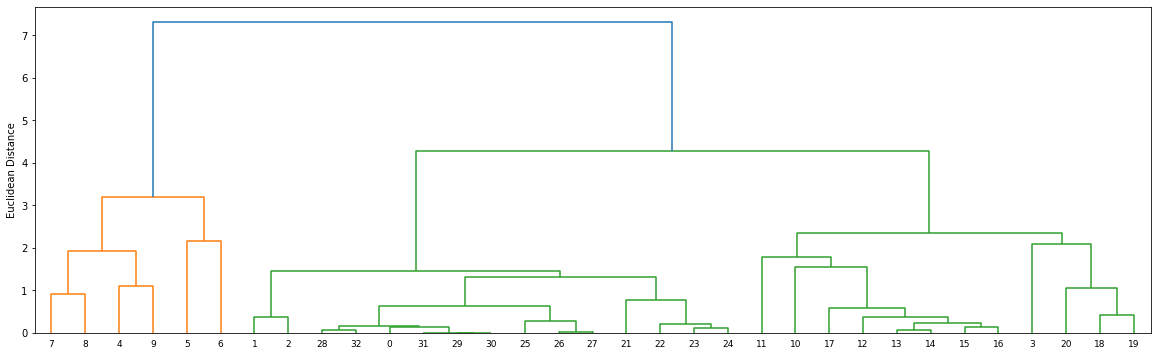

In [16]:
clusters = hierarchy.linkage(data_PCA.iloc[:,1:].values, method="centroid")

def plot_dendrogram(clusters):
    plt.figure(figsize=(20,6))
    dendrogram = hierarchy.dendrogram(clusters, orientation="top",leaf_font_size=9, leaf_rotation=360)
    plt.ylabel('Euclidean Distance')
    
plot_dendrogram(clusters)